In [88]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer

## CIFAR10 dataset

In [30]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding = 'bytes')
    return data

In [31]:
def roll_cifar(flat_images):
    """
    Vectorized impl that rolls array of images.
    
    flat_images -- of shape (m, 3072, ), m images, first red channel pixels, then green, then blue.
    
    Returns:
    images -- of shape (m, 32, 32, 3)
    """
    (m, _) = flat_images.shape
    images = np.zeros((m, 32, 32, 3))
    images[:, :, :, 0] = flat_images[:, 0:1024].reshape((-1, 32, 32))
    images[:, :, :, 1] = flat_images[:, 1024:2048].reshape((-1, 32, 32))
    images[:, :, :, 2] = flat_images[:, 2048:3072].reshape((-1, 32, 32))
    return images.astype(np.uint8)

In [32]:
train_batch1 = unpickle("cifar10/cifar-10-batches-py/data_batch_1")
test_batch = unpickle("cifar10/cifar-10-batches-py/test_batch")
X_train = roll_cifar(train_batch1[b'data']) / 255.
X_test = roll_cifar(test_batch[b'data']) / 255.

binarizer = LabelBinarizer().fit(train_batch1[b'labels'])
Y_train = binarizer.transform(train_batch1[b'labels'])
Y_test = binarizer.transform(test_batch[b'labels'])

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("Y_train: ", Y_train.shape)
print("Y_test: ", Y_test.shape)

X_train:  (10000, 32, 32, 3)
X_test:  (10000, 32, 32, 3)
Y_train:  (10000, 10)
Y_test:  (10000, 10)


In [33]:
train_batch1[b'labels'][0:10], test_batch[b'labels'][0:10]

([6, 9, 9, 4, 1, 1, 2, 7, 8, 3], [3, 8, 8, 0, 6, 6, 1, 6, 3, 1])

In [34]:
Y_train[0:10, :], Y_test[0:10, :]

(array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]]),
 array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]))

In [69]:
X_train_small = X_train[0:500, :]
Y_train_small = Y_train[0:500, :]
X_test_small = X_test[0:200, :]
Y_test_small = Y_test[0:200, :]

## The problem of very deep neural networks

In recent years, neural networks have become deeper, with state-of-the-art networks going from just a few layers (e.g., AlexNet) to over a hundred layers.

The main benefit of a very deep network is that it can represent very complex functions. It can also learn features at many different levels of abstraction, from edges (at the lower layers) to very complex features (at the deeper layers). However, using a deeper network doesn't always help. A huge barrier to training them is vanishing gradients: very deep networks often have a gradient signal that goes to zero quickly, thus making gradient descent unbearably slow. More specifically, during gradient descent, as you backprop from the final layer back to the first layer, you are multiplying by the weight matrix on each step, and thus the gradient can decrease exponentially quickly to zero (or, in rare cases, grow exponentially quickly and "explode" to take very large values). 

During training, you might therefore see the magnitude (or norm) of the gradient for the earlier layers descrease to zero very rapidly as training proceeds: 

<img src="img/vanishing_grad_kiank.png" style="width:450px;height:220px;">
<caption><center> <u> <font color='purple'> **Figure 1** </u><font color='purple'>  : **Vanishing gradient** <br> The speed of learning decreases very rapidly for the early layers as the network trains </center></caption>

You are now going to solve this problem by building a Residual Network!

## Buidling a Residual Network

In ResNets, a "shortcut" or a "skip connection" allows the gradient to be directly backpropagated to earlier layers:  

<img src="img/skip_connection_kiank.png" style="width:650px;height:200px;">
<caption><center> <u> <font color='purple'> **Figure 2** </u><font color='purple'>  : A ResNet block showing a **skip-connection** <br> </center></caption>

The image on the left shows the "main path" through the network. The image on the right adds a shortcut to the main path. By stacking these ResNet blocks on top of each other, you can form a very deep network. 

We also saw in lecture that having ResNet blocks with the shortcut also makes it very easy for one of the blocks to learn an identity function. This means that you can stack on additional ResNet blocks with little risk of harming training set performance. (There is also some evidence that the ease of learning an identity function--even more than skip connections helping with vanishing gradients--accounts for ResNets' remarkable performance.)

Two main types of blocks are used in a ResNet, depending mainly on whether the input/output dimensions are same or different. You are going to implement both of them. 

### 1 - The identity block

The identity block is the standard block used in ResNets, and corresponds to the case where the input activation (say $a^{[l]}$) has the same dimension as the output activation (say $a^{[l+2]}$). To flesh out the different steps of what happens in a ResNet's identity block, here is an alternative diagram showing the individual steps:

<img src="img/idblock2_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 3** </u><font color='purple'>  : **Identity block.** Skip connection "skips over" 2 layers. </center></caption>

The upper path is the "shortcut path." The lower path is the "main path." In this diagram, we have also made explicit the CONV2D and ReLU steps in each layer. To speed up training we have also added a BatchNorm step. 

In this exercise, you'll actually implement a slightly more powerful version of this identity block, in which the skip connection "skips over" 3 hidden layers rather than 2 layers. It looks like this: 

<img src="img/idblock3_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 4** </u><font color='purple'>  : **Identity block.** Skip connection "skips over" 3 layers.</center></caption>

Here're the individual steps.

First component of main path: 
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid" and its name should be `conv_name_base + '2a'`. Use 0 as the seed for the random initialization. 
- The first BatchNorm is normalizing the channels axis.  Its name should be `bn_name_base + '2a'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape $(f,f)$ and a stride of (1,1). Its padding is "same" and its name should be `conv_name_base + '2b'`. Use 0 as the seed for the random initialization. 
- The second BatchNorm is normalizing the channels axis.  Its name should be `bn_name_base + '2b'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid" and its name should be `conv_name_base + '2c'`. Use 0 as the seed for the random initialization. 
- The third BatchNorm is normalizing the channels axis.  Its name should be `bn_name_base + '2c'`. Note that there is no ReLU activation function in this component. 

Final step: 
- The shortcut and the input are added together.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 


In [37]:
def create_filter(f, n_C_prev, n_C, name):
    filter_var = tf.get_variable(name, shape = [f, f, n_C_prev, n_C], 
                                 initializer = tf.contrib.layers.xavier_initializer())
    return filter_var

def identity_block(X, filters, f, stage, block, phase, bn_decay):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    f -- integer, specifying the shape of the middle CONV's window for the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    phase -- bool, whether this is the training phase
    bn_decay -- decay rate for calculating the population statistics in batch normalization
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    conv_name_base = 'res' + str(stage) + block + '_'
    
    X_shortcut = X
    (m, n_H_prev, n_W_prev, n_C_prev) = X.shape
    # Make sure number of output_channels is the same as number of input_channels
    if n_C_prev != filters[2]:
        raise ValueError("Inconsistent dimension: Input has " + n_C_prev + " channels, output has " + filters[2] + " channels.")    
    
    F1 = create_filter(1, n_C_prev, filters[0], conv_name_base + '2a_filter')
    F2 = create_filter(f, filters[0], filters[1], conv_name_base + '2b_filter')
    F3 = create_filter(1, filters[1], filters[2], conv_name_base + '2c_filter')
        
    # first component
    X = tf.nn.conv2d(X, F1, strides = [1, 1, 1, 1], padding = 'VALID', name = conv_name_base + '2a')
    X = tf.contrib.layers.batch_norm(X, center = True, scale = True, is_training = phase, decay = bn_decay)
    X = tf.nn.relu(X)
    
    # Second component
    X = tf.nn.conv2d(X, F2, strides = [1, 1, 1, 1], padding = 'SAME', name = conv_name_base + '2b')
    X = tf.contrib.layers.batch_norm(X, center = True, scale = True, is_training = phase, decay = bn_decay)
    X = tf.nn.relu(X)
    
    # Third component
    X = tf.nn.conv2d(X, F3, strides = [1, 1, 1, 1], padding = 'VALID', name = conv_name_base + '2c')
    X = tf.contrib.layers.batch_norm(X, center = True, scale = True, is_training = phase, decay = bn_decay)
    
    # Final step
    X = X_shortcut + X
    X = tf.nn.relu(X)
    
    return X
    

### 2 - The convolutional block

You've implemented the ResNet identity block. Next, the ResNet "convolutional block" is the other type of block. You can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path: 

<img src="img/convblock_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 5** </u><font color='purple'>  : **Convolutional block** </center></caption>

The CONV2D layer in the shortcut path is used to resize the input $x$ to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path. (This plays a similar role as the matrix $W_s$ discussed in lecture.) For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a 1x1 convolution with a stride of 2. The CONV2D layer on the shortcut path does not use any non-linear activation function. Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step. 

The details of the convolutional block are as follows. 

First component of main path:
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid" and its name should be `conv_name_base + '2a'`. 
- The first BatchNorm is normalizing the channels axis.  Its name should be `bn_name_base + '2a'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of (f,f) and a stride of (1,1). Its padding is "same" and it's name should be `conv_name_base + '2b'`.
- The second BatchNorm is normalizing the channels axis.  Its name should be `bn_name_base + '2b'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of (1,1) and a stride of (1,1). Its padding is "valid" and it's name should be `conv_name_base + '2c'`.
- The third BatchNorm is normalizing the channels axis.  Its name should be `bn_name_base + '2c'`. Note that there is no ReLU activation function in this component. 

Shortcut path:
- The CONV2D has $F_3$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid" and its name should be `conv_name_base + '1'`.
- The BatchNorm is normalizing the channels axis.  Its name should be `bn_name_base + '1'`. 

Final step: 
- The shortcut and the main path values are added together.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 
    

In [41]:
def convolutional_block(X, filters, f, stage, block, phase, bn_decay, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 5
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    f -- integer, specifying the shape of the middle CONV's window for the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    phase -- bool, whether this is the training phase
    s -- Integer, specifying the stride to be used
    bn_decay -- decay rate for calculating the population statistics in batch normalization

    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    conv_name_base = 'res' + str(stage) + block + '_'
    
    X_shortcut = X
    (m, n_H_prev, n_W_prev, n_C_prev) = X.shape
    
    F1 = create_filter(1, n_C_prev, filters[0], conv_name_base + '2a_filter')
    F2 = create_filter(f, filters[0], filters[1], conv_name_base + '2b_filter')
    F3 = create_filter(1, filters[1], filters[2], conv_name_base + '2c_filter')
    F4 = create_filter(1, n_C_prev, filters[2], conv_name_base + '1_filter')
        
    # first component
    X = tf.nn.conv2d(X, F1, strides = [1, s, s, 1], padding = 'VALID', name = conv_name_base + '2a')
    X = tf.contrib.layers.batch_norm(X, center = True, scale = True, is_training = phase, decay = bn_decay)
    X = tf.nn.relu(X)
    
    # second component
    X = tf.nn.conv2d(X, F2, strides = [1, 1, 1, 1], padding = 'SAME', name = conv_name_base + '2b')
    X = tf.contrib.layers.batch_norm(X, center = True, scale = True, is_training = phase, decay = bn_decay)
    X = tf.nn.relu(X)
    
    # third component
    X = tf.nn.conv2d(X, F3, strides = [1, 1, 1, 1], padding = 'VALID', name = conv_name_base + '2c')
    X = tf.contrib.layers.batch_norm(X, center = True, scale = True, is_training = phase, decay = bn_decay)

    # Shortcut path
    X_shortcut = tf.nn.conv2d(X_shortcut, F4, strides = [1, s, s, 1], padding = 'VALID', name = conv_name_base + '1')
    X_shortcut = tf.contrib.layers.batch_norm(X_shortcut, center = True, scale = True, is_training = phase, decay = bn_decay)
    
    X = X + X_shortcut
    x = tf.nn.relu(X)
    
    return X

## Building ResNet (50 layers)

## 3 - Building your first ResNet model (50 layers)

You now have the necessary blocks to build a very deep ResNet. The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.

<img src="img/resnet_kiank.png" style="width:850px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 6** </u><font color='purple'>  : **ResNet-50 model** </center></caption>

The details of this ResNet-50 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). Its name is "conv1".
    - BatchNorm is applied to the channels axis of the input.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three set of filters of size [64,64,256], "f" is 3, "s" is 1 and the block is "a".
    - The 2 identity blocks use three set of filters of size [64,64,256], "f" is 3 and the blocks are "b" and "c".
- Stage 3:
    - The convolutional block uses three set of filters of size [128,128,512], "f" is 3, "s" is 2 and the block is "a".
    - The 3 identity blocks use three set of filters of size [128,128,512], "f" is 3 and the blocks are "b", "c" and "d".
- Stage 4:
    - The convolutional block uses three set of filters of size [256, 256, 1024], "f" is 3, "s" is 2 and the block is "a".
    - The 5 identity blocks use three set of filters of size [256, 256, 1024], "f" is 3 and the blocks are "b", "c", "d", "e" and "f".
- Stage 5:
    - The convolutional block uses three set of filters of size [512, 512, 2048], "f" is 3, "s" is 2 and the block is "a".
    - The 2 identity blocks use three set of filters of size [512, 512, 2048], "f" is 3 and the blocks are "b" and "c".
- The 2D Average Pooling uses a window of shape (2,2) and its name is "avg_pool".
- The flatten doesn't have any hyperparameters or name.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation. Its name should be `'fc' + str(classes)`.


In [77]:
def ResNet50(X, phase, bn_decay):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    """
    
    # stage 1
    F = create_filter(7, 3, 64, 'conv1_filter')
    X = tf.nn.conv2d(X, F, strides = [1, 2, 2, 1], padding = 'SAME', name = 'conv1')
    X = tf.contrib.layers.batch_norm(X, center = True, scale = True, is_training = phase, decay = bn_decay)
    X = tf.nn.relu(X)
    X = tf.nn.max_pool(X, ksize = [1, 3, 3, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    
    # stage 2
    X = convolutional_block(X, filters = [64, 64, 256], f = 3, stage = 2, block = 'a', phase = phase, bn_decay = bn_decay, s = 1)
    X = identity_block(X, filters = [64, 64, 256], f = 3, stage = 2, block = 'b', phase = phase, bn_decay = bn_decay)
    X = identity_block(X, filters = [64, 64, 256], f = 3, stage = 2, block = 'c', phase = phase, bn_decay = bn_decay)
    
    # stage 3
    X = convolutional_block(X, filters = [128, 128, 512], f = 3, stage = 3, block = 'a', phase = phase, bn_decay = bn_decay, s = 2)
    X = identity_block(X, filters = [128, 128, 512], f = 3, stage = 3, block = 'b', phase = phase, bn_decay = bn_decay)
    X = identity_block(X, filters = [128, 128, 512], f = 3, stage = 3, block = 'c', phase = phase, bn_decay = bn_decay)
    X = identity_block(X, filters = [128, 128, 512], f = 3, stage = 3, block = 'd', phase = phase, bn_decay = bn_decay)

    # stage 4
    X = convolutional_block(X, filters = [256, 256, 1024], f = 3, stage = 4, block = 'a', phase = phase, bn_decay = bn_decay, s = 2)
    X = identity_block(X, filters = [256, 256, 1024], f = 3, stage = 4, block = 'b', phase = phase, bn_decay = bn_decay)
    X = identity_block(X, filters = [256, 256, 1024], f = 3, stage = 4, block = 'c', phase = phase, bn_decay = bn_decay)
    X = identity_block(X, filters = [256, 256, 1024], f = 3, stage = 4, block = 'd', phase = phase, bn_decay = bn_decay)
    X = identity_block(X, filters = [256, 256, 1024], f = 3, stage = 4, block = 'e', phase = phase, bn_decay = bn_decay)
    X = identity_block(X, filters = [256, 256, 1024], f = 3, stage = 4, block = 'f', phase = phase, bn_decay = bn_decay)
    
    # stage 5
    X = convolutional_block(X, filters = [512, 512, 2048], f = 3, stage = 5, block = 'a', phase = phase, bn_decay = bn_decay, s = 2)
    X = identity_block(X, filters = [512, 512, 2048], f = 3, stage = 5, block = 'b', phase = phase, bn_decay = bn_decay)
    X = identity_block(X, filters = [512, 512, 2048], f = 3, stage = 5, block = 'c', phase = phase, bn_decay = bn_decay)
    
    # finishing
    X = tf.nn.avg_pool(X, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    X = tf.contrib.layers.flatten(X)
    X = tf.contrib.layers.fully_connected(X, 10, activation_fn = None)
        
    return X

In [83]:
def ResNet11(X, phase, bn_decay):
    """
    A simplied version of ResNet with only 11 layers

    """
    
    # stage 1
    F = create_filter(7, 3, 64, 'conv1_filter')
    X = tf.nn.conv2d(X, F, strides = [1, 2, 2, 1], padding = 'SAME', name = 'conv1')
    X = tf.contrib.layers.batch_norm(X, center = True, scale = True, is_training = phase, decay = bn_decay)
    X = tf.nn.relu(X)
    X = tf.nn.max_pool(X, ksize = [1, 3, 3, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    
    # stage 2
    X = convolutional_block(X, filters = [64, 64, 256], f = 3, stage = 2, block = 'a', phase = phase, bn_decay = bn_decay, s = 1)
    X = identity_block(X, filters = [64, 64, 256], f = 3, stage = 2, block = 'b', phase = phase, bn_decay = bn_decay)
    X = identity_block(X, filters = [64, 64, 256], f = 3, stage = 2, block = 'c', phase = phase, bn_decay = bn_decay)
    
    # stage 3
    """X = convolutional_block(X, filters = [128, 128, 512], f = 3, stage = 3, block = 'a', phase = phase, bn_decay = bn_decay, s = 2)
    X = identity_block(X, filters = [128, 128, 512], f = 3, stage = 3, block = 'b', phase = phase, bn_decay = bn_decay)
    X = identity_block(X, filters = [128, 128, 512], f = 3, stage = 3, block = 'c', phase = phase, bn_decay = bn_decay)
    X = identity_block(X, filters = [128, 128, 512], f = 3, stage = 3, block = 'd', phase = phase, bn_decay = bn_decay)

    # stage 4
    X = convolutional_block(X, filters = [256, 256, 1024], f = 3, stage = 4, block = 'a', phase = phase, bn_decay = bn_decay, s = 2)
    X = identity_block(X, filters = [256, 256, 1024], f = 3, stage = 4, block = 'b', phase = phase, bn_decay = bn_decay)
    X = identity_block(X, filters = [256, 256, 1024], f = 3, stage = 4, block = 'c', phase = phase, bn_decay = bn_decay)
    X = identity_block(X, filters = [256, 256, 1024], f = 3, stage = 4, block = 'd', phase = phase, bn_decay = bn_decay)
    X = identity_block(X, filters = [256, 256, 1024], f = 3, stage = 4, block = 'e', phase = phase, bn_decay = bn_decay)
    X = identity_block(X, filters = [256, 256, 1024], f = 3, stage = 4, block = 'f', phase = phase, bn_decay = bn_decay)
    
    # stage 5
    X = convolutional_block(X, filters = [512, 512, 2048], f = 3, stage = 5, block = 'a', phase = phase, bn_decay = bn_decay, s = 2)
    X = identity_block(X, filters = [512, 512, 2048], f = 3, stage = 5, block = 'b', phase = phase, bn_decay = bn_decay)
    X = identity_block(X, filters = [512, 512, 2048], f = 3, stage = 5, block = 'c', phase = phase, bn_decay = bn_decay)
    """
    # finishing
    X = tf.nn.avg_pool(X, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    X = tf.contrib.layers.flatten(X)
    X = tf.contrib.layers.fully_connected(X, 10, activation_fn = None)
        
    return X

In [78]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (m, n_H, n_W, n_C)
    Y -- true "label" vector, of shape (m, #classes)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[0]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation, :]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = np.floor(m/mini_batch_size).astype(int) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[(k * mini_batch_size) : ((k + 1) * mini_batch_size), :]
        mini_batch_Y = shuffled_Y[(k * mini_batch_size) : ((k + 1) * mini_batch_size), :]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[(num_complete_minibatches * mini_batch_size) : m, :]
        mini_batch_Y = shuffled_Y[(num_complete_minibatches * mini_batch_size) : m, :]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [79]:
def compute_loss(output, Y):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = output, labels = Y))

def compute_accuracy(output, Y):
    return tf.reduce_mean(tf.cast(tf.equal(tf.argmax(output, axis = 1), tf.argmax(Y, axis = 1)), 'float32'))

In [85]:
def train(X_training, Y_training, X_test, Y_test, learning_rate = 0.009, num_epochs = 100, minibatch_size = 16):
    
    tf.reset_default_graph()

    m = X_training.shape[0]
    X = tf.placeholder(tf.float32, [None, 32, 32, 3])
    Y = tf.placeholder(tf.float32, [None, 10])
    phase = tf.placeholder(tf.bool)
    bn_decay = tf.placeholder(tf.float32)
    
    #output = ResNet50(X, phase, bn_decay)  # Very slow to train
    output = ResNet11(X, phase, bn_decay)
    loss = compute_loss(output, Y)
    accuracy = compute_accuracy(output, Y)
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_step = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
    
    train_accuracies = []
    test_accuracies = []
    
    decay = 0.9
    minibatch_seed = 0
    init = tf.global_variables_initializer()
    with tf.Session() as session:
        session.run(init)
        for i in range(num_epochs):
            num_minibatches = m / minibatch_size
            minibatch_seed = minibatch_seed + 1
            mini_batches = random_mini_batches(X_training, Y_training, minibatch_size, minibatch_seed)
            for minibatch in mini_batches:
                (X_mini, Y_mini) = minibatch
                session.run(train_step, feed_dict = {X: X_mini, Y: Y_mini, phase: True, bn_decay: decay})
            
            print(session.run(loss, feed_dict = {X: X_training, Y: Y_training, phase: False, bn_decay: decay}))
            
            train_accuracy = session.run(accuracy, feed_dict = {X: X_training, Y: Y_training, phase: False, bn_decay: decay})
            train_accuracies.append(train_accuracy)
            
            test_accuracy = session.run(accuracy, feed_dict = {X: X_test, Y: Y_test, phase: False, bn_decay: decay})
            test_accuracies.append(test_accuracy)

    return train_accuracies, test_accuracies
        

In [81]:
train_accuracies, test_accuracies = train(X_train_small, Y_train_small, X_test_small, Y_test_small, num_epochs = 10, minibatch_size = 32)

180.758
9.04345
3.50405
1.93495
1.67911
1.65209
1.594
1.04682
1.03578
0.765493


In [82]:
train_accuracies, test_accuracies

([0.11,
  0.19599999,
  0.27200001,
  0.35600001,
  0.44,
  0.55199999,
  0.52399999,
  0.65200001,
  0.61799997,
  0.73000002],
 [0.15000001,
  0.16,
  0.22,
  0.215,
  0.25,
  0.27500001,
  0.25,
  0.33000001,
  0.28,
  0.34])

In [86]:
train_accuracies, test_accuracies = train(X_train, Y_train, X_test, Y_test, num_epochs = 10, minibatch_size = 100)

1.77212
1.79892
1.25339
1.14722
1.15524
1.13833
1.19067
0.760321
0.642394
1.10358


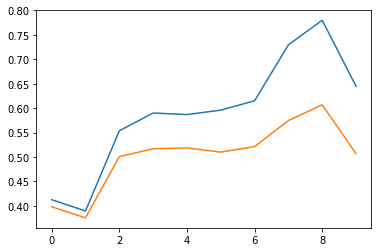

In [90]:
import matplotlib.pyplot as plt
figure = plt.figure()
ax = figure.add_subplot(1, 1, 1)
ax.plot(train_accuracies, label="train_accuracy")
ax.plot(test_accuracies, label="test_accuracy")
plt.show()

In [91]:
train_accuracies, test_accuracies

([0.4127,
  0.38960001,
  0.5535,
  0.5898,
  0.58670002,
  0.59570003,
  0.61479998,
  0.72920001,
  0.77950001,
  0.64450002],
 [0.39820001,
  0.37540001,
  0.5007,
  0.51679999,
  0.51849997,
  0.50999999,
  0.52109998,
  0.57440001,
  0.60659999,
  0.50700003])

Well, at least better than the previous 3-layer model in the 10th notebook.

<font color='blue'>
**What we should remember:**
- Very deep "plain" networks don't work in practice because they are hard to train due to vanishing gradients.  
- The skip-connections help to address the Vanishing Gradient problem. They also make it easy for a ResNet block to learn an identity function. 
- There are two main type of blocks: The identity block and the convolutional block. 
- Very deep Residual Networks are built by stacking these blocks together.

### References 

This notebook presents the ResNet algorithm due to He et al. (2015). The implementation here also took significant inspiration and follows the structure given in the github repository of Francois Chollet: 

- Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun - [Deep Residual Learning for Image Recognition (2015)](https://arxiv.org/abs/1512.03385)
- Francois Chollet's github repository: https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py
